In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklego.preprocessing import RepeatingBasisFunction
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_log_error

## 1. Load data

In [310]:
# load data
df = pd.read_csv('../data/train.csv', parse_dates=['datetime'])
df.head(5)

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [311]:
# split into x and y data
X = df.drop(['count', 'casual', 'registered'], axis=1)
Y = df['count']

## 2. FEATURE ENGINEERING

### 2.1 Create time features

In [312]:
# create new columns with the result of 3_1 EDA (hour, (day), week, month, quarter, year)
X_eng = X
X_eng['hour'] = X_eng['datetime'].dt.hour
X_eng['day'] = X_eng['datetime'].dt.day
X_eng['week'] = X_eng['datetime'].dt.week
X_eng['dayofyear'] = X_eng['datetime'].dt.dayofyear
X_eng['month'] = X_eng['datetime'].dt.month
X_eng['quarter'] = X_eng['datetime'].dt.quarter
X_eng['year'] = X_eng['datetime'].dt.year
X_eng = X_eng.drop('datetime', axis=1)
X_eng.head(5)

/tmp/ipykernel_6562/3644887806.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  X_eng['week'] = X_eng['datetime'].dt.week


season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   hour  day  week  dayofyear  month  quarter  year  
0     0    1    52          1      1        1  2011  
1     1    1    52          1      1        1  2011  
2     2    1    52          1      1        1  2011  
3     3    1    52          1      1        1  2011  
4     4    1    52          1      1        1  2011

In [313]:
# check how many days have been cut off for test data
X_eng['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

### 2.2 CHECK FOR MISSING VALUES

In [314]:
X_eng.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
hour          0
day           0
week          0
dayofyear     0
month         0
quarter       0
year          0
dtype: int64

### 2.3 feature preselection

#### 2.3.1 Correlation of features with target

In [315]:
# 1. check the correlations of the features with target (count)
df_month = pd.merge(X_eng, Y, left_index=True, right_index=True)
df_month.corr()['count']

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
hour          0.400601
day           0.019826
week          0.152512
dayofyear     0.168056
month         0.166862
quarter       0.163439
year          0.260403
count         1.000000
Name: count, dtype: float64

#### 2.3.2 weights from linear regression

In [316]:
# split the data for a linear regression
Xtrain, Xval, ytrain, yval = train_test_split(X_eng, Y, test_size=0.2, random_state=42)


In [317]:
# sort xtrain and ytrain by index to get better graphs 
Xtrain.sort_index(inplace=True)
ytrain.sort_index(inplace=True)

In [318]:
# make a copy for polynomial features
Xtrain_poly = Xtrain.copy()
Xval_poly = Xval.copy()

In [319]:
# define the model
mod_lin = LinearRegression()
mod_lin.fit(Xtrain, ytrain)
mod_lin.score(Xtrain, ytrain), mod_lin.score(Xval, yval)

(0.3877086711719542, 0.3954035162552456)

In [320]:
# check the weights
df_weight = pd.DataFrame(data={'feature': mod_lin.feature_names_in_, 'weight': mod_lin.coef_})
df_weight['weight_absolute'] = df_weight['weight'].abs()
df_weight.sort_values(by='weight_absolute', ascending=False, inplace=True)
df_weight

feature     weight  weight_absolute
14        year  82.592229        82.592229
1      holiday  -8.816308         8.816308
8         hour   7.873416         7.873416
12       month   7.474765         7.474765
3      weather  -5.231740         5.231740
5        atemp   5.023110         5.023110
13     quarter  -3.791016         3.791016
0       season  -3.791016         3.791016
6     humidity  -2.024230         2.024230
4         temp   1.150394         1.150394
7    windspeed   0.545541         0.545541
10        week  -0.545207         0.545207
2   workingday   0.456350         0.456350
11   dayofyear   0.158030         0.158030
9          day   0.095666         0.095666

conclusion: year, holiday, hour, month, weather, atemp, quarter, humidity

In [321]:
# check sense of high weight of year
df = pd.merge(left=Xtrain, right=ytrain, left_index=True, right_index=True)
df.groupby(by='year')['count'].describe()

count        mean         std  min   25%    50%    75%    max
year                                                                
2011  4340.0  144.476498  133.778848  1.0  32.0  110.0  211.0  638.0
2012  4368.0  238.391026  207.721821  1.0  60.0  199.0  353.0  970.0

#### 2.3.3 loop over linear regression with 1 feature

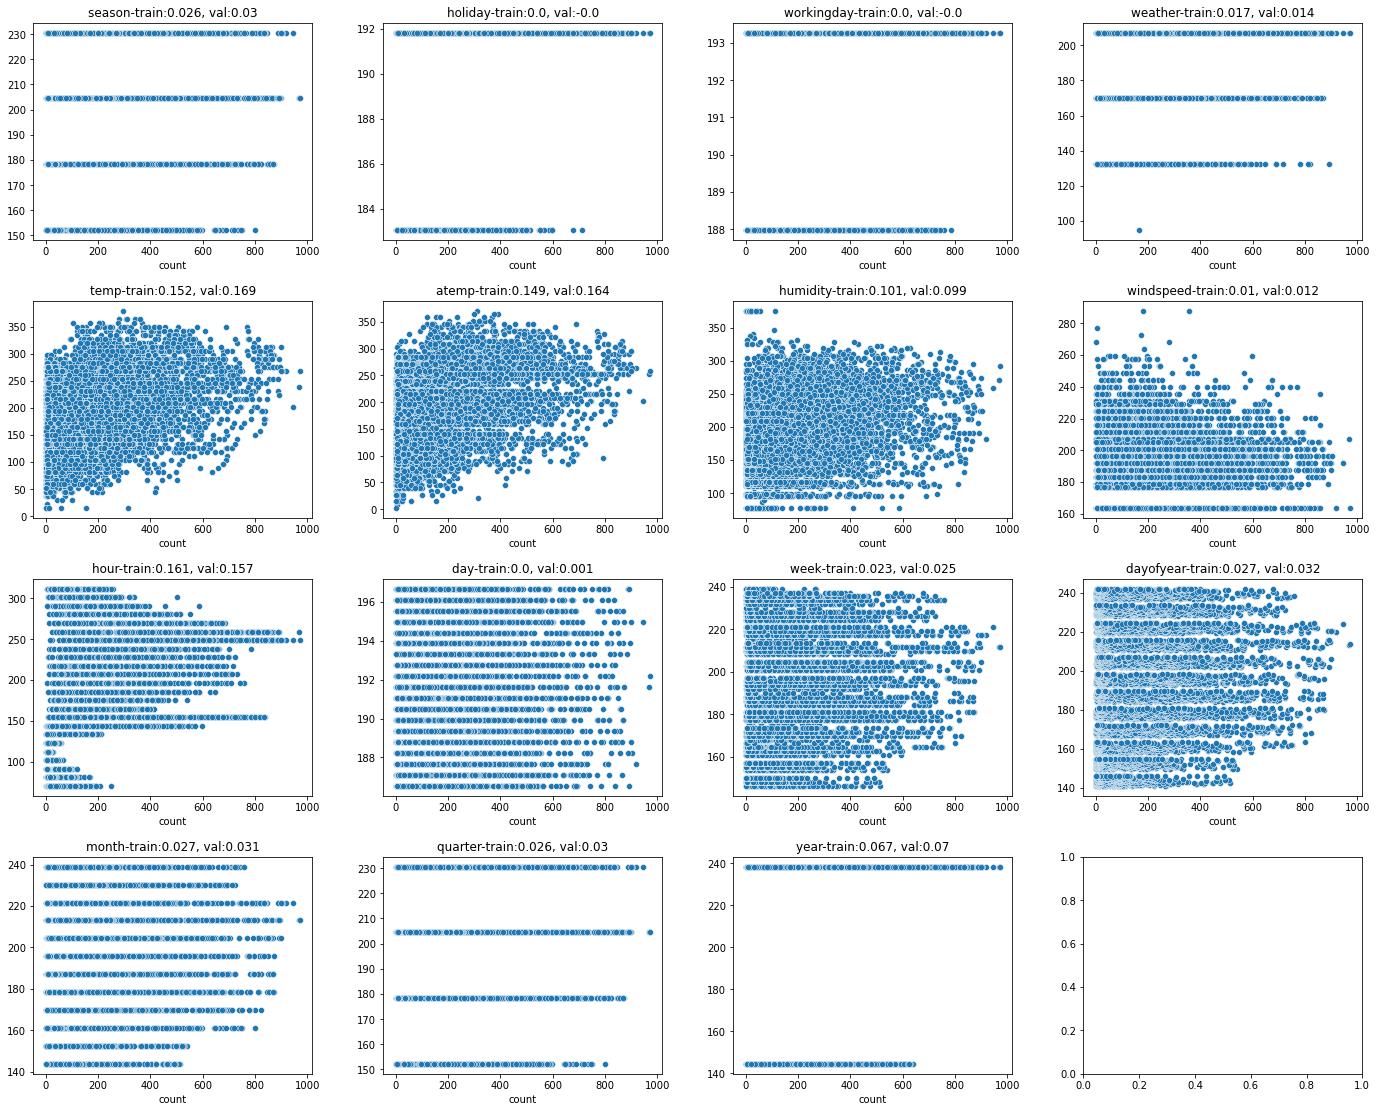

In [322]:
# train model with 1 feature, calculate score and plot a scatterplot for all features
fig, axs = plt.subplots(figsize = (20, 16), nrows=4, ncols=4)
fig.tight_layout(pad=4)
for i, feature in enumerate(Xtrain.columns):
    mod_lin.fit(Xtrain[[feature]], ytrain)
    y_pred = mod_lin.predict(Xtrain[[feature]])
    sns.scatterplot(x=ytrain, y=y_pred, ax=axs[i // 4][i % 4])
    score_train = np.round(mod_lin.score(Xtrain[[feature]], ytrain), 3)
    score_val = np.round(mod_lin.score(Xval[[feature]], yval), 3)
    axs[i // 4][i % 4].set_title(f"{feature}-train:{score_train}, val:{score_val}")
plt.show()

conclusions: temp, atemp, hour, humidity, year are important

putting conclusions of all 3 pre-selection methods together:
hour, temp, atemp, humidity, holiday, weather, month, quarter and year


## 3. FEATURE ENGINEERING

### 3.1 Deleting Features (no corr, small weights)

In [323]:
# excluding things with bad correlation or small weights
Xtrain = Xtrain[['workingday', 'temp', 'atemp', 'humidity', 'hour', 'dayofyear', 'week', 'month', 'quarter', 'year']]
Xval = Xval[['workingday', 'temp', 'atemp', 'humidity', 'hour', 'dayofyear', 'week', 'month', 'quarter', 'year']]
Xtrain.head(5)

workingday  temp   atemp  humidity  hour  dayofyear  week  month  quarter  \
1           0  9.02  13.635        80     1          1    52      1        1   
2           0  9.02  13.635        80     2          1    52      1        1   
4           0  9.84  14.395        75     4          1    52      1        1   
5           0  9.84  12.880        75     5          1    52      1        1   
6           0  9.02  13.635        80     6          1    52      1        1   

   year  
1  2011  
2  2011  
4  2011  
5  2011  
6  2011

quarter (too high correlation with month), day of year and week will be left out later.

In [324]:
# train model with less features -> score remains the same
mod_lin.fit(Xtrain, ytrain)
mod_lin.score(Xtrain, ytrain), mod_lin.score(Xval, yval)

(0.3869653101568332, 0.39446202032172295)

In [325]:
# check the weights
df_weight = pd.DataFrame(data={'feature': mod_lin.feature_names_in_, 'weight': mod_lin.coef_})
df_weight['weight_absolute'] = df_weight['weight'].abs()
df_weight.sort_values(by='weight_absolute', ascending=False, inplace=True)
df_weight

feature     weight  weight_absolute
9        year  81.974917        81.974917
8     quarter  -8.589411         8.589411
4        hour   7.869708         7.869708
2       atemp   4.608886         4.608886
7       month   3.970816         3.970816
3    humidity  -2.163983         2.163983
1        temp   1.596054         1.596054
0  workingday   1.002200         1.002200
6        week  -0.504691         0.504691
5   dayofyear   0.276858         0.276858

### 3.2 PLOT ALL Y/X[feature] relations

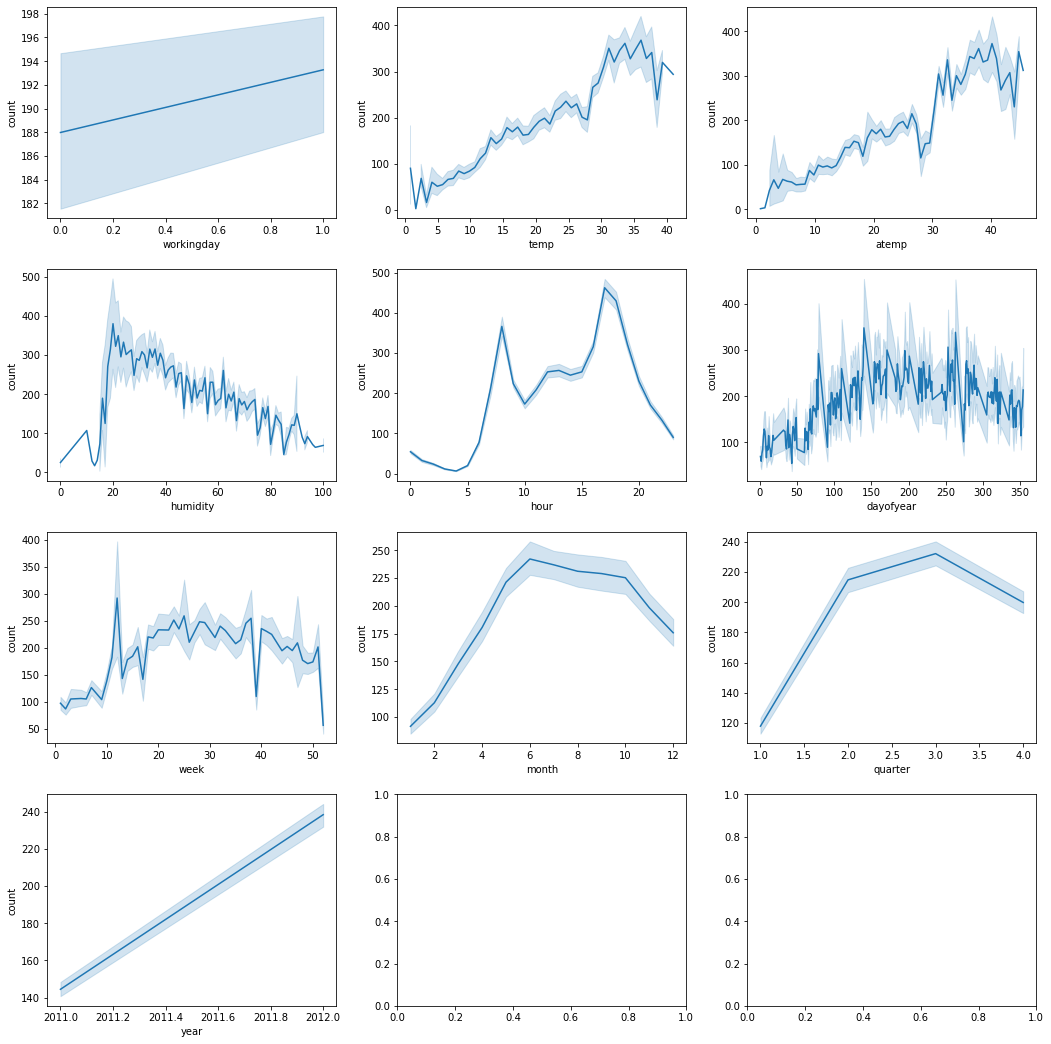

In [326]:
fig, axs = plt.subplots(figsize=(15,15), nrows=4, ncols=3)
fig.tight_layout(pad=3)
df_plot = pd.merge(Xtrain, ytrain, left_index=True, right_index=True)
# iterate over all columns but the target column (last one)
for i, feature in enumerate(df_plot.columns[:-1]):
    sns.lineplot(data=df_plot, x=feature, y='count', ax=axs[i // 3][i % 3])

### 3.3 Repeating Basis functions

#### 3.3.1 RBF for hours

In [327]:
# using 18 columns with normal distribution every 4/3 hour instead of hour
rbf = RepeatingBasisFunction(n_periods=18,
                         	column="hour",
                         	input_range=(0,23),
                         	remainder="drop")
rbf.fit(Xtrain[['hour']])

RepeatingBasisFunction(column='hour', input_range=(0, 23), n_periods=18)

hour             0             1             2             3  \
1         1  5.420070e-01  9.538403e-01  2.271734e-01  7.322348e-03   
2         2  8.630174e-02  7.265335e-01  8.277568e-01  1.276324e-01   
4         4  5.547257e-05  1.068673e-02  2.786266e-01  9.831307e-01   
5         5  2.239352e-07  2.063736e-04  2.573932e-02  4.344613e-01   
6         6  2.655682e-10  1.170775e-06  6.985243e-04  5.640281e-02   
...     ...           ...           ...           ...           ...   
10878    16  9.252087e-14  5.937290e-19  5.156416e-25  6.060641e-32   
10880    18  2.239352e-07  3.288527e-11  6.535693e-16  1.757895e-21   
10881    19  5.547257e-05  3.896931e-08  3.704914e-12  4.766994e-17   
10882    20  4.036863e-03  1.356606e-05  6.169848e-09  3.797574e-13   
10883    21  8.630174e-02  1.387377e-03  3.018426e-06  8.887458e-10   

                  4             5             6             7             8  \
1      3.194142e-05  1.885685e-08  1.506590e-12  1.629042e-17  2.383857e-23   
2      2.663361e-03  7.521601e-06  2.874760e-09  1.486976e-13  1.040919e-18   
4      4.694734e-01  3.034043e-02  2.653649e-04  3.141061e-07  5.031764e-11   
5      9.924671e-01  3.068260e-01  1.283746e-02  7.269045e-05  5.570401e-08   
6      6.163551e-01  9.115329e-01  1.824419e-01  4.941833e-03  1.811601e-05   
...             ...           ...           ...           ...           ...   
10878  2.894132e-32  2.686039e-25  3.373786e-19  5.735003e-14  1.319352e-09   
10880  6.398896e-28  3.152306e-35  3.959437e-29  1.540211e-22  8.108451e-17   
10881  8.300842e-23  1.956189e-29  6.829771e-35  1.270920e-27  3.200672e-21   
10882  3.163363e-18  3.566177e-24  5.440862e-31  3.080816e-33  3.711540e-26   
10883  3.541487e-14  1.909874e-19  1.393911e-25  1.376817e-32  1.264378e-31   

                  9            10            11            12            13  \
1      4.721058e-30  3.169829e-34  4.956993e-27  1.049088e-20  3.004806e-15   
2      9.861466e-25  1.264378e-31  1.376817e-32  1.393911e-25  1.909874e-19   
4      1.090875e-15  3.200672e-21  1.270920e-27  6.829771e-35  1.956189e-29   
5      5.777057e-12  8.108451e-17  1.540211e-22  3.959437e-29  3.152306e-35   
6      8.987688e-09  6.034544e-13  5.483426e-18  6.743271e-24  1.122277e-30   
...             ...           ...           ...           ...           ...   
10878  4.107703e-06  1.730806e-03  9.869806e-02  7.616930e-01  7.955405e-01   
10880  5.777057e-12  5.570401e-08  7.269045e-05  1.283746e-02  3.068260e-01   
10881  1.090875e-15  5.031764e-11  3.141061e-07  2.653649e-04  3.034043e-02   
10882  6.051366e-20  1.335254e-14  3.987358e-10  1.611453e-06  8.813758e-04   
10883  9.861466e-25  1.040919e-18  1.486976e-13  2.874760e-09  7.521601e-06   

                 14            15            16            17  
1      1.164748e-10  6.110246e-07  4.338069e-04  4.168167e-02  
2      3.541487e-14  8.887458e-10  3.018426e-06  1.387377e-03  
4      8.300842e-23  4.766994e-17  3.704914e-12  3.896931e-08  
5      6.398896e-28  1.757895e-21  6.535693e-16  3.288527e-11  
6      1.449098e-33  1.904368e-26  3.386997e-20  8.152484e-15  
...             ...           ...           ...           ...  
10878  1.124490e-01  2.151098e-03  5.568980e-06  1.951202e-09  
10880  9.924671e-01  4.344613e-01  2.573932e-02  2.063736e-04  
10881  4.694734e-01  9.831307e-01  2.786266e-01  1.068673e-02  
10882  6.524025e-02  6.535535e-01  8.860490e-01  1.625719e-01  
10883  2.663361e-03  1.276324e-01  8.277568e-01  7.265335e-01  

[8708 rows x 19 columns]

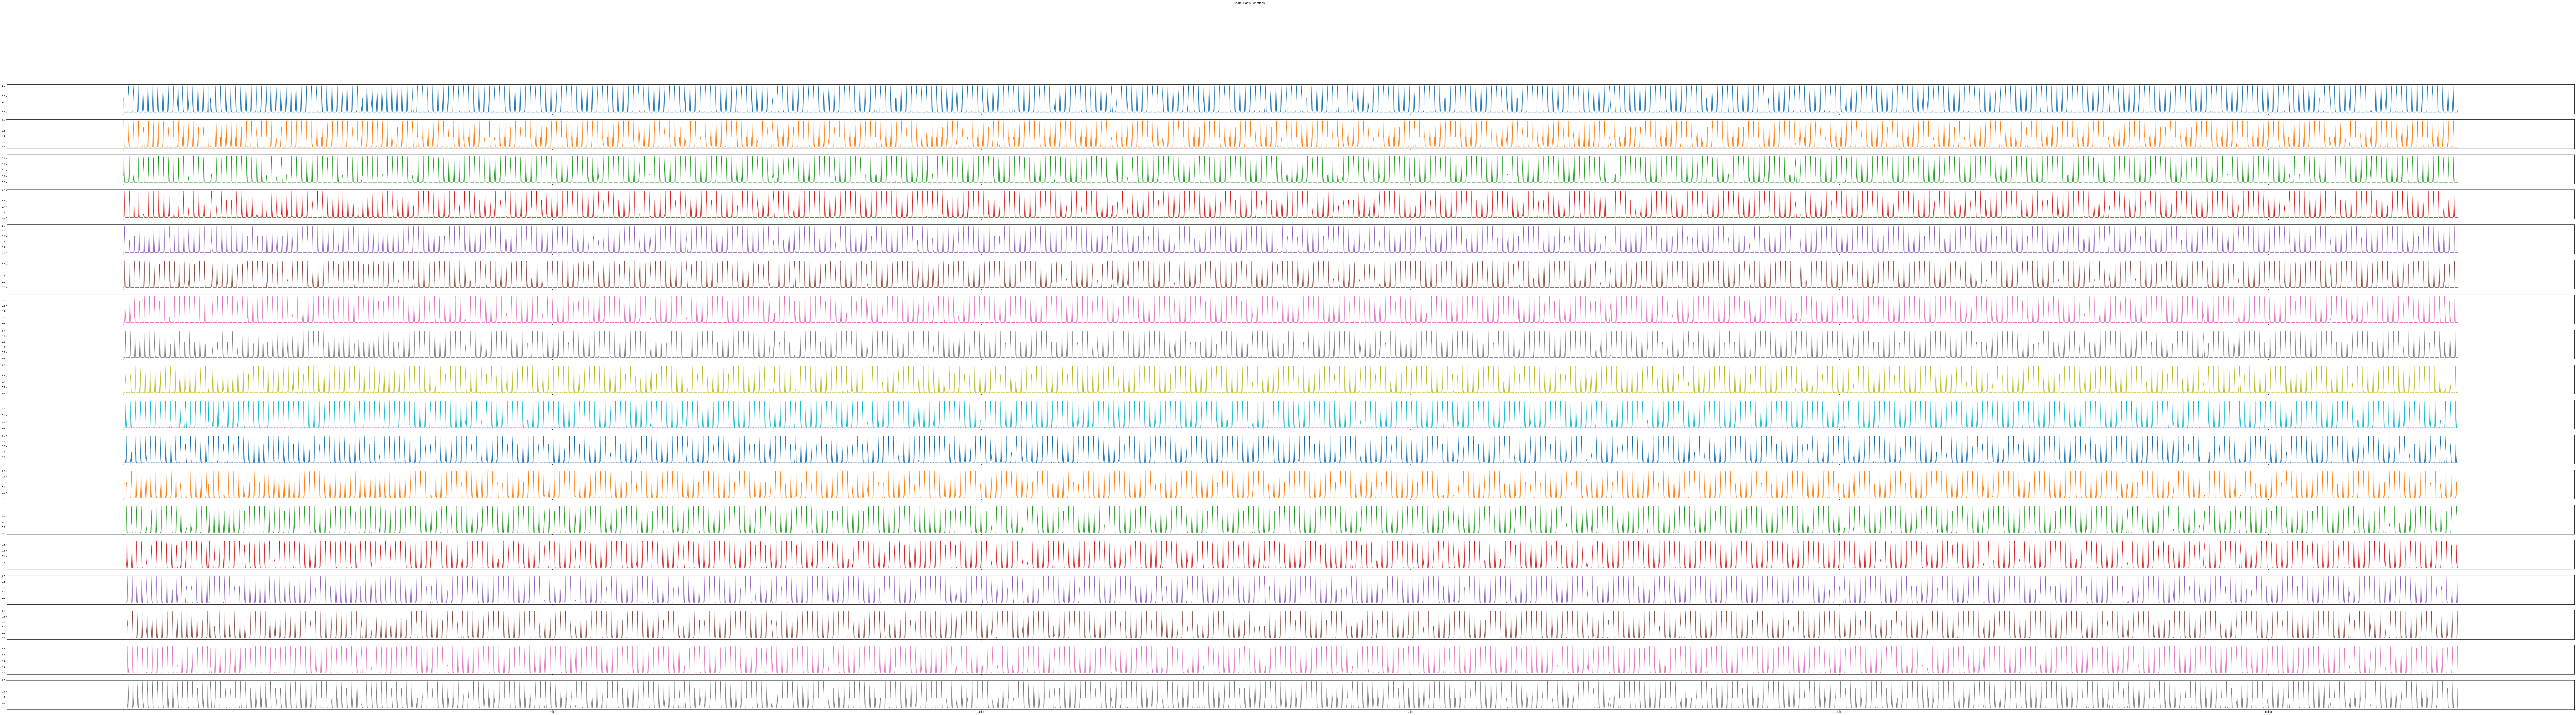

In [328]:
# check if repeating basis function worked
X_rbf_train = pd.DataFrame(index=Xtrain.index,
               	data=rbf.transform(Xtrain[['hour']]))

X_rbf_train.plot(subplots=True, figsize=(200, 50),
     	sharex=True, title="Radial Basis Functions",
     	legend=False);

X_rbf_val = pd.DataFrame(index=Xval.index,
               	data=rbf.transform(Xval[['hour']]))

pd.merge(Xtrain[['hour']], X_rbf_train, left_index=True, right_index=True)

#### 3.3.2 RBF for months

In [329]:
# using 12 columns with normal distribution every 365/12 periods/year instead of month
rbf = RepeatingBasisFunction(n_periods=12,
                         	column="dayofyear",
                         	input_range=(1,365),
                         	remainder="drop")
rbf.fit(Xtrain[['dayofyear']])

RepeatingBasisFunction(column='dayofyear', input_range=(1, 365))

month         0         1         2         3             4  \
1          1  1.000000  0.367879  0.018316  0.000123  1.125352e-07   
2          1  1.000000  0.367879  0.018316  0.000123  1.125352e-07   
4          1  1.000000  0.367879  0.018316  0.000123  1.125352e-07   
5          1  1.000000  0.367879  0.018316  0.000123  1.125352e-07   
6          1  1.000000  0.367879  0.018316  0.000123  1.125352e-07   
...      ...       ...       ...       ...       ...           ...   
10878     12  0.876774  0.156175  0.003765  0.000012  5.423065e-09   
10880     12  0.876774  0.156175  0.003765  0.000012  5.423065e-09   
10881     12  0.876774  0.156175  0.003765  0.000012  5.423065e-09   
10882     12  0.876774  0.156175  0.003765  0.000012  5.423065e-09   
10883     12  0.876774  0.156175  0.003765  0.000012  5.423065e-09   

                  5             6             7             8         9  \
1      1.388794e-11  2.319523e-16  1.388794e-11  1.125352e-07  0.000123   
2      1.388794e-11  2.319523e-16  1.388794e-11  1.125352e-07  0.000123   
4      1.388794e-11  2.319523e-16  1.388794e-11  1.125352e-07  0.000123   
5      1.388794e-11  2.319523e-16  1.388794e-11  1.125352e-07  0.000123   
6      1.388794e-11  2.319523e-16  1.388794e-11  1.125352e-07  0.000123   
...             ...           ...           ...           ...       ...   
10878  3.240497e-13  1.578277e-14  4.575512e-10  1.795177e-06  0.000953   
10880  3.240497e-13  1.578277e-14  4.575512e-10  1.795177e-06  0.000953   
10881  3.240497e-13  1.578277e-14  4.575512e-10  1.795177e-06  0.000953   
10882  3.240497e-13  1.578277e-14  4.575512e-10  1.795177e-06  0.000953   
10883  3.240497e-13  1.578277e-14  4.575512e-10  1.795177e-06  0.000953   

             10        11  
1      0.018316  0.367879  
2      0.018316  0.367879  
4      0.018316  0.367879  
5      0.018316  0.367879  
6      0.018316  0.367879  
...         ...       ...  
10878  0.068498  0.666156  
10880  0.068498  0.666156  
10881  0.068498  0.666156  
10882  0.068498  0.666156  
10883  0.068498  0.666156  

[8708 rows x 13 columns]

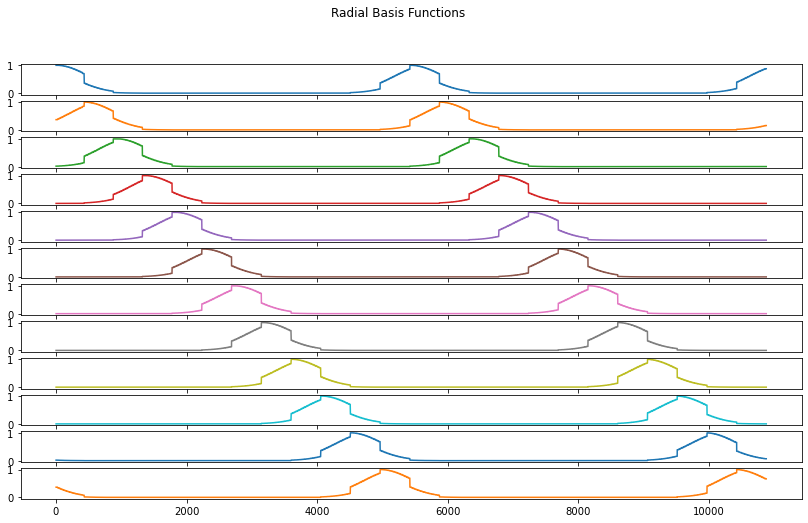

In [330]:
# check if repeating basis function worked
X_rbf_month_train = pd.DataFrame(index=Xtrain.index,
               	data=rbf.transform(Xtrain[['dayofyear']]))

X_rbf_month_train.plot(subplots=True, figsize=(14, 8),
     	sharex=True, title="Radial Basis Functions",
     	legend=False);

X_rbf_month_val = pd.DataFrame(index=Xval.index,
               	data=rbf.transform(Xval[['dayofyear']]))

pd.merge(Xtrain[['month']], X_rbf_month_train, left_index=True, right_index=True)

### 3.4. Alternative: Sinus-Cosine transformer on month and hour (not used)

#### 3.4.1 Make a sinus curve out of month (only the positive part of sinus curve)

In [331]:
def sin_transformer(period):
    '''function transforms the data to the positive part of a sinus curve with the frequency of 
    the parameter period. It will apply 1 sinus value per month'''
    return FunctionTransformer(lambda x: np.sin((x - 1) / period * np.pi))
Xtrain_month = Xtrain[['month']].copy()
Xval_month = Xval[['month']].copy()
Xtrain_month["month_sin"] = sin_transformer(12).fit_transform(Xtrain_month)
Xval_month["month_sin"] = sin_transformer(12).fit_transform(Xval_month)
# check if transformation worked
Xtrain_month.groupby('month').value_counts()

month  month_sin
1      0.000000     692
2      0.258819     724
3      0.500000     724
4      0.707107     719
5      0.866025     739
6      0.965926     736
7      1.000000     729
8      0.965926     745
9      0.866025     713
10     0.707107     730
11     0.500000     741
12     0.258819     716
dtype: int64

#### 3.4.1 Make a sinus-/cosine curve out of hour

In [332]:
# x-axis: sinus, y-axis: cosine: will give a circle of radius = 1 repeating every 24 hours
# 0: clock at 12 o'clock position. 12: clock at 6 o'clock position
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

Xtrain_hour = Xtrain[['hour']].copy()
Xval_hour = Xval[['hour']].copy()
Xtrain_hour["hour_sin"] = sin_transformer(24).fit_transform(Xtrain_hour)["hour"]
Xtrain_hour["hour_cos"] = cos_transformer(24).fit_transform(Xtrain_hour)["hour"]
Xval_hour["hour_sin"] = sin_transformer(24).fit_transform(Xval_hour)["hour"]
Xval_hour["hour_cos"] = cos_transformer(24).fit_transform(Xval_hour)["hour"]
Xtrain_hour[16:36]

hour  hour_sin      hour_cos
22    22 -0.500000  8.660254e-01
24     0  0.000000  1.000000e+00
25     1  0.258819  9.659258e-01
26     2  0.500000  8.660254e-01
27     3  0.707107  7.071068e-01
28     4  0.866025  5.000000e-01
30     7  0.965926 -2.588190e-01
32     9  0.707107 -7.071068e-01
34    11  0.258819 -9.659258e-01
37    14 -0.500000 -8.660254e-01
38    15 -0.707107 -7.071068e-01
40    17 -0.965926 -2.588190e-01
41    18 -1.000000 -1.836970e-16
42    19 -0.965926  2.588190e-01
43    20 -0.866025  5.000000e-01
44    21 -0.707107  7.071068e-01
45    22 -0.500000  8.660254e-01
46    23 -0.258819  9.659258e-01
48     1  0.258819  9.659258e-01
49     4  0.866025  5.000000e-01

### 3.5 Feature enigeering on the other data

#### 3.5.1 Min-Max-Scaler for numerical features

In [333]:
# min max scale temperature for numerical features
numerical_features = ['atemp', 'humidity', 'dayofyear', 'week']
scaler = MinMaxScaler()
scal_x_train = scaler.fit_transform(Xtrain[numerical_features])
scal_x_val = scaler.transform(Xval[numerical_features])
df_scale_x_train = pd.DataFrame(data=scal_x_train, index=Xtrain.index, columns=scaler.get_feature_names_out())
df_scale_x_val = pd.DataFrame(data=scal_x_val, index=Xval.index, columns=scaler.get_feature_names_out())
df_scale_x_train.head(5)

atemp  humidity  dayofyear  week
1  0.288064      0.80        0.0   1.0
2  0.288064      0.80        0.0   1.0
4  0.305068      0.75        0.0   1.0
5  0.271171      0.75        0.0   1.0
6  0.288064      0.80        0.0   1.0

#### 3.5.2 one hot encoder for categorical features

In [334]:
# one hot encoder for categorical features temperature
categorical_features = ['workingday', 'quarter', 'year']
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_x_train = ohe.fit_transform(Xtrain[categorical_features])
ohe_x_val = ohe.transform(Xval[categorical_features])
df_ohe_x_train = pd.DataFrame(data=ohe_x_train, index=Xtrain.index, columns=ohe.get_feature_names_out())
df_ohe_x_val = pd.DataFrame(data=ohe_x_val, index=Xval.index, columns=ohe.get_feature_names_out())
df_ohe_x_train.head(5)

workingday_1  quarter_2  quarter_3  quarter_4  year_2012
1           0.0        0.0        0.0        0.0        0.0
2           0.0        0.0        0.0        0.0        0.0
4           0.0        0.0        0.0        0.0        0.0
5           0.0        0.0        0.0        0.0        0.0
6           0.0        0.0        0.0        0.0        0.0

### 3.6 Merge the engineered features together

In [335]:
# add the dataframes together again
Xtrain_fe = pd.concat([df_ohe_x_train, df_scale_x_train, X_rbf_month_train, X_rbf_train], axis=1)
Xval_fe = pd.concat([df_ohe_x_val, df_scale_x_val, X_rbf_month_val, X_rbf_val], axis=1)
Xtrain_fe.columns = ['workingday_1', 'quarter_2', 'quarter_3', 'quarter_4', 'year_2012', 'atemp',
       'humidity', 'dayofyear', 'week', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
        'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
        'hour_16', 'hour_17']
Xval_fe.columns = ['workingday_1', 'quarter_2', 'quarter_3', 'quarter_4', 'year_2012', 'atemp',
       'humidity', 'dayofyear', 'week', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
        'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
        'hour_16', 'hour_17']



In [336]:
# make other dataset with sinus and cosinus hours
Xtrain_fe_2 = pd.concat([df_ohe_x_train, df_scale_x_train, X_rbf_month_train, Xtrain_hour], axis=1)
Xval_fe_2 = pd.concat([df_ohe_x_val, df_scale_x_val, X_rbf_month_val, Xval_hour], axis=1)
Xtrain_fe_2.drop(['hour'], axis=1, inplace=True)
Xval_fe_2.drop(['hour'], axis=1, inplace=True)
Xtrain_fe_2.head(5)

workingday_1  quarter_2  quarter_3  quarter_4  year_2012     atemp  \
1           0.0        0.0        0.0        0.0        0.0  0.288064   
2           0.0        0.0        0.0        0.0        0.0  0.288064   
4           0.0        0.0        0.0        0.0        0.0  0.305068   
5           0.0        0.0        0.0        0.0        0.0  0.271171   
6           0.0        0.0        0.0        0.0        0.0  0.288064   

   humidity  dayofyear  week    0  ...             4             5  \
1      0.80        0.0   1.0  1.0  ...  1.125352e-07  1.388794e-11   
2      0.80        0.0   1.0  1.0  ...  1.125352e-07  1.388794e-11   
4      0.75        0.0   1.0  1.0  ...  1.125352e-07  1.388794e-11   
5      0.75        0.0   1.0  1.0  ...  1.125352e-07  1.388794e-11   
6      0.80        0.0   1.0  1.0  ...  1.125352e-07  1.388794e-11   

              6             7             8         9        10        11  \
1  2.319523e-16  1.388794e-11  1.125352e-07  0.000123  0.018316  0.367879   
2  2.319523e-16  1.388794e-11  1.125352e-07  0.000123  0.018316  0.367879   
4  2.319523e-16  1.388794e-11  1.125352e-07  0.000123  0.018316  0.367879   
5  2.319523e-16  1.388794e-11  1.125352e-07  0.000123  0.018316  0.367879   
6  2.319523e-16  1.388794e-11  1.125352e-07  0.000123  0.018316  0.367879   

   hour_sin      hour_cos  
1  0.258819  9.659258e-01  
2  0.500000  8.660254e-01  
4  0.866025  5.000000e-01  
5  0.965926  2.588190e-01  
6  1.000000  6.123234e-17  

[5 rows x 23 columns]

### 3.7 Train the models to check score

#### 3.7.1. Linear Regression Model 

In [337]:
# train the model
mod_lin.fit(Xtrain_fe, ytrain)
print(mod_lin.score(Xtrain_fe, ytrain), mod_lin.score(Xval_fe, yval))
print(mod_lin.coef_)

0.6836507088462773 0.6877379417697499
[ 1.40425973e+00 -7.55222818e+01 -1.07376270e+02 -1.40921688e+02
  8.53798394e+01  1.88811249e+02 -1.20785751e+02  2.46729229e+02
 -2.39441157e+01  9.85509624e+03  9.91262698e+03  9.81884157e+03
  9.93943726e+03  9.92317390e+03  9.92585675e+03  9.88780376e+03
  9.92786277e+03  9.86040690e+03  9.95524225e+03  9.88657958e+03
  9.90544317e+03  5.21896447e+06  5.22025920e+06  5.22119491e+06
  5.21945744e+06  5.21923883e+06  5.22093279e+06  5.22095832e+06
  5.21908392e+06  5.21991285e+06  5.22137830e+06  5.21996756e+06
  5.21912616e+06  5.22070205e+06  5.22120396e+06  5.21945140e+06
  5.21961518e+06  5.22126363e+06  5.22033709e+06]


model has extreme high weights 10⁶

#### 3.7.2. Linear Regression Model with ridge loss function

In [338]:
mod_ridge = Ridge(alpha=10.0)
mod_ridge.fit(Xtrain_fe, ytrain)
print(mod_ridge.score(Xtrain_fe, ytrain), mod_ridge.score(Xval_fe, yval))
print(mod_ridge.coef_)

0.680724157593489 0.6838136733264752
[   2.21080357  -14.47561625  -13.09119704   -9.78679327   86.00840285
  170.29309834 -115.30520375   87.49862545   -9.49037298  -35.22191511
   -7.53099174  -32.75160493   13.81752823   13.87489824   37.45645102
  -14.15748816    8.9344501    -9.42079615   34.15963945  -15.58030581
    6.29644822  -70.47616156  -90.44550872  -80.88582345 -114.77450675
  -63.42763783 -105.65816312  196.99193016    2.4358755   -46.10096467
   37.89147332   17.01386683   27.60661026  -29.68551069  142.34529529
  165.14127236   33.06612249   -5.25112899  -15.79018475]


model weights reduced to 10²

### 3.8 create polynomial features from atemp and humidity

In [339]:
# create the df for adding the polynomial for month and quarter
polynomial_features = ['atemp', 'humidity']
features_left_out=['quarter','dayofyear', 'week']

#The “include_bias” argument defaults to True to include the bias feature
poly = PolynomialFeatures(include_bias=False, interaction_only=False, degree=3)
poly_train = poly.fit_transform(df_scale_x_train[polynomial_features])
poly_val = poly.transform(df_scale_x_val[polynomial_features])
df_poly_train = pd.DataFrame(data=poly_train, index=Xtrain.index, columns=poly.get_feature_names_out())
df_poly_val = pd.DataFrame(data=poly_val, index=Xval.index, columns=poly.get_feature_names_out())

Xtrain_poly = pd.concat([Xtrain_fe[['workingday_1', 'year_2012', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11']], df_poly_train], axis=1)
       
Xval_poly = pd.concat([Xval_fe[['workingday_1', 'year_2012', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11']], df_poly_val], axis=1)


Xtrain_poly

workingday_1  year_2012        hour_0        hour_1        hour_2  \
1               0.0        0.0  5.420070e-01  9.538403e-01  2.271734e-01   
2               0.0        0.0  8.630174e-02  7.265335e-01  8.277568e-01   
4               0.0        0.0  5.547257e-05  1.068673e-02  2.786266e-01   
5               0.0        0.0  2.239352e-07  2.063736e-04  2.573932e-02   
6               0.0        0.0  2.655682e-10  1.170775e-06  6.985243e-04   
...             ...        ...           ...           ...           ...   
10878           1.0        1.0  9.252087e-14  5.937290e-19  5.156416e-25   
10880           1.0        1.0  2.239352e-07  3.288527e-11  6.535693e-16   
10881           1.0        1.0  5.547257e-05  3.896931e-08  3.704914e-12   
10882           1.0        1.0  4.036863e-03  1.356606e-05  6.169848e-09   
10883           1.0        1.0  8.630174e-02  1.387377e-03  3.018426e-06   

             hour_3        hour_4        hour_5        hour_6        hour_7  \
1      7.322348e-03  3.194142e-05  1.885685e-08  1.506590e-12  1.629042e-17   
2      1.276324e-01  2.663361e-03  7.521601e-06  2.874760e-09  1.486976e-13   
4      9.831307e-01  4.694734e-01  3.034043e-02  2.653649e-04  3.141061e-07   
5      4.344613e-01  9.924671e-01  3.068260e-01  1.283746e-02  7.269045e-05   
6      5.640281e-02  6.163551e-01  9.115329e-01  1.824419e-01  4.941833e-03   
...             ...           ...           ...           ...           ...   
10878  6.060641e-32  2.894132e-32  2.686039e-25  3.373786e-19  5.735003e-14   
10880  1.757895e-21  6.398896e-28  3.152306e-35  3.959437e-29  1.540211e-22   
10881  4.766994e-17  8.300842e-23  1.956189e-29  6.829771e-35  1.270920e-27   
10882  3.797574e-13  3.163363e-18  3.566177e-24  5.440862e-31  3.080816e-33   
10883  8.887458e-10  3.541487e-14  1.909874e-19  1.393911e-25  1.376817e-32   

       ...  month_11     atemp  humidity   atemp^2  atemp humidity  \
1      ...  0.367879  0.288064      0.80  0.082981        0.230451   
2      ...  0.367879  0.288064      0.80  0.082981        0.230451   
4      ...  0.367879  0.305068      0.75  0.093066        0.228801   
5      ...  0.367879  0.271171      0.75  0.073534        0.203378   
6      ...  0.367879  0.288064      0.80  0.082981        0.230451   
...    ...       ...       ...       ...       ...             ...   
10878  ...  0.666156  0.457546      0.50  0.209348        0.228773   
10880  ...  0.666156  0.423649      0.50  0.179479        0.211825   
10881  ...  0.666156  0.423649      0.50  0.179479        0.211825   
10882  ...  0.666156  0.372860      0.57  0.139025        0.212530   
10883  ...  0.666156  0.338964      0.61  0.114897        0.206768   

       humidity^2   atemp^3  atemp^2 humidity  atemp humidity^2  humidity^3  
1          0.6400  0.023904          0.066384          0.184361    0.512000  
2          0.6400  0.023904          0.066384          0.184361    0.512000  
4          0.5625  0.028392          0.069800          0.171601    0.421875  
5          0.5625  0.019940          0.055150          0.152534    0.421875  
6          0.6400  0.023904          0.066384          0.184361    0.512000  
...           ...       ...               ...               ...         ...  
10878      0.2500  0.095786          0.104674          0.114386    0.125000  
10880      0.2500  0.076036          0.089739          0.105912    0.125000  
10881      0.2500  0.076036          0.089739          0.105912    0.125000  
10882      0.3249  0.051837          0.079244          0.121142    0.185193  
10883      0.3721  0.038946          0.070087          0.126129    0.226981  

[8708 rows x 41 columns]

### 3.9 train the models with new features

#### 3.9.1 linear regression model

In [340]:
# train the model
mod_lin_poly = LinearRegression()
mod_lin_poly.fit(Xtrain_poly, ytrain)
print(mod_lin_poly.score(Xtrain_poly, ytrain), mod_lin_poly.score(Xval_poly, yval))

0.6980169552167457 0.7011386124706696


#### 3.9.2 linear regression model with ridge loss function

In [341]:
# regularize the model
mod_ridge_poly = Ridge(alpha=2.0)
mod_ridge_poly.fit(Xtrain_poly, ytrain)
mod_ridge_poly.score(Xtrain_poly, ytrain), mod_ridge_poly.score(Xval_poly, yval) 

(0.6901363281015296, 0.6914664622912935)

## 4. MSLE for both datasets and both models (train and validation data)

In [345]:
# Lin. Regression, no ploy, no 
msle_lin_train = mean_squared_log_error(ytrain, np.where(mod_lin.predict(Xtrain_fe) < 0, 0, mod_lin.predict(Xtrain_fe)))
msle_lin_val = mean_squared_log_error(yval, np.where(mod_lin.predict(Xval_fe) < 0, 0, mod_lin.predict(Xval_fe)))
print(f"lin Regr. FE: {msle_lin_train}, {msle_lin_val}")
msle_lin_ridge_train = mean_squared_log_error(ytrain, np.where(mod_ridge.predict(Xtrain_fe) < 0, 0, mod_ridge.predict(Xtrain_fe)))
msle_lin_ridge_val = mean_squared_log_error(yval, np.where(mod_ridge.predict(Xval_fe) < 0, 0, mod_ridge.predict(Xval_fe)))
print(f"lin Regr. Ridge FE: {msle_lin_ridge_train }, {msle_lin_ridge_val}")
msle_poly_train = mean_squared_log_error(ytrain, np.where(mod_lin_poly.predict(Xtrain_poly) < 0, 0, mod_lin_poly.predict(Xtrain_poly)))
msle_poly_val = mean_squared_log_error(yval, np.where(mod_lin_poly.predict(Xval_poly) < 0, 0, mod_lin_poly.predict(Xval_poly)))
print(f"lin Regr. poly: {msle_poly_train}, {msle_poly_val}")
msle_poly_ridge_train = mean_squared_log_error(ytrain, np.where(mod_ridge_poly.predict(Xtrain_poly) < 0, 0, mod_ridge_poly.predict(Xtrain_poly)))
msle_poly_ridge_val = mean_squared_log_error(yval, np.where(mod_ridge_poly.predict(Xval_poly) < 0, 0, mod_ridge_poly.predict(Xval_poly)))
print(f"lin Regr. Ridge poly: {msle_poly_ridge_train}, {msle_poly_ridge_val}")

lin Regr. FE: 1.270098316291429, 1.2129918969803122
lin Regr. Ridge FE: 1.2622604431930802, 1.2217496387499216
lin Regr. poly: 1.2990615442230564, 1.2295758584745993
lin Regr. Ridge poly: 1.2784070354241366, 1.2334963195867283
